In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from thop import profile, clever_format

In [21]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, relu=True, same_padding=False, bn=False):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) / 2) if same_padding else 0
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else None
        self.relu = nn.ReLU(inplace=True) if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class MCNN(nn.Module):
    def __init__(self, bn=False):
        super(MCNN, self).__init__()
        self.branch1 = nn.Sequential(nn.Conv2d(1, 16, 9, stride=1, padding=int((9 - 1) / 2)),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(16, 32, 7, stride=1, padding=int((7 - 1) / 2)),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(32, 16, 7, stride=1, padding=int((7 - 1) / 2)),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(16, 8, 7, stride=1, padding=int((7 - 1) / 2)),
                                     nn.ReLU(inplace=True),
                                    )

        self.branch2 = nn.Sequential(nn.Conv2d(1, 20, 7, stride=1, padding=int((7 - 1) / 2)),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(20, 40, 5, stride=1, padding=int((5 - 1) / 2)),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(40, 20, 5, stride=1, padding=int((5 - 1) / 2)),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(20, 10, 5, stride=1, padding=int((5 - 1) / 2)),
                                     nn.ReLU(inplace=True),
                                    )

        self.branch3 = nn.Sequential(nn.Conv2d(1, 24, 5, stride=1, padding=int((5 - 1) / 2)),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(24, 48, 3, stride=1, padding=int((3 - 1) / 2)),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(2),
                                     nn.Conv2d(48, 24, 3, stride=1, padding=int((3 - 1) / 2)),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(24, 12, 3, stride=1, padding=int((3 - 1) / 2)),
                                     nn.ReLU(inplace=True),
                                    )

        self.fuse = nn.Sequential(nn.Conv2d(30, 1, 1, stride=1, padding=int((1 - 1) / 2)),
                                     nn.ReLU(inplace=True),
                                 )
            
    def forward(self, im_data):
        x1 = self.branch1(im_data)
        x2 = self.branch2(im_data)
        x3 = self.branch3(im_data)
        x = torch.cat((x1, x2, x3), 1)
        x = self.fuse(x)
        return x

In [22]:
MCNN()

MCNN(
  (branch1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (7): ReLU(inplace=True)
    (8): Conv2d(16, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (9): ReLU(inplace=True)
  )
  (branch2): Sequential(
    (0): Conv2d(1, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

MCNN

In [13]:
net = MCNN()
flop, para = profile(net, (torch.randn((1, 1, 512, 512)),))
macs, params = clever_format([flop, para], "%.3f")
print(macs)
print(params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.MCNN'>. Treat it as zero Macs and zero Params.
22.198G
127.953K


Cascaded-MTL

In [17]:
class CMTL(nn.Module):
    '''
    Implementation of CNN-based Cascaded Multi-task Learning of High-level Prior and Density
    Estimation for Crowd Counting (Sindagi et al.)
    '''
    def __init__(self, bn=False, num_classes=10):
        super(CMTL, self).__init__()
        
        self.num_classes = num_classes        
        self.base_layer = nn.Sequential(nn.Conv2d(1, 16, 9, stride=1, padding=int((9 - 1) / 2)),
                                        nn.PReLU(),
                                        nn.Conv2d(16, 32, 7, stride=1, padding=int((7 - 1) / 2)),
                                        nn.PReLU(),
                                       )
        
        self.hl_prior_1 = nn.Sequential(nn.Conv2d(32, 16, 9, stride=1, padding=int((9 - 1) / 2)),
                                        nn.PReLU(),
                                        nn.MaxPool2d(2),
                                        nn.Conv2d(16, 32, 7, stride=1, padding=int((7 - 1) / 2)),
                                        nn.PReLU(),
                                        nn.MaxPool2d(2),
                                        nn.Conv2d(32, 16, 7, stride=1, padding=int((7 - 1) / 2)),
                                        nn.PReLU(),
                                        nn.Conv2d(16, 8, 7, stride=1, padding=int((7 - 1) / 2)),
                                        nn.PReLU(),
                                       )
                
        self.hl_prior_2 = nn.Sequential(nn.AdaptiveMaxPool2d((32,32)),
                                        nn.Conv2d(8, 4, 1, stride=1, padding=int((1 - 1) / 2)),
                                        nn.PReLU(),
                                       )
                                        
        self.hl_prior_fc1 = nn.Linear(4*1024, 512) 
        self.hl_prior_fc2 = nn.Linear(512, 256) 
        self.hl_prior_fc3 = nn.Linear(256, self.num_classes)
        
        self.de_stage_1 = nn.Sequential(
                                        nn.Conv2d(32, 20, 7, stride=1, padding=int((7 - 1) / 2)),
                                        nn.PReLU(),
                                        nn.MaxPool2d(2),
                                        nn.Conv2d(20, 40, 5, stride=1, padding=int((5 - 1) / 2)),
                                        nn.PReLU(),
                                        nn.MaxPool2d(2),
                                        nn.Conv2d(40, 20, 5, stride=1, padding=int((5 - 1) / 2)),
                                        nn.PReLU(),
                                        nn.Conv2d(20, 10, 5, stride=1, padding=int((5 - 1) / 2)),
                                        nn.PReLU(),
                                        )
        
        self.de_stage_2 = nn.Sequential(
                                        nn.Conv2d(18, 24, 3, stride=1, padding=int((3 - 1) / 2)),
                                        nn.PReLU(),
                                        nn.Conv2d(24, 32, 3, stride=1, padding=int((3 - 1) / 2)),
                                        nn.PReLU(),            
                                        nn.ConvTranspose2d(32,16,4,stride=2,padding=1,output_padding=0,bias=True),
                                        nn.PReLU(),
                                        nn.ConvTranspose2d(16,8,4,stride=2,padding=1,output_padding=0,bias=True),
                                        nn.PReLU(),
                                        nn.Conv2d(8, 1, 1, stride=1, padding=int((1 - 1) / 2)),
                                        nn.ReLU(),  
                                        )
                    
    def forward(self, im_data):
        x_base = self.base_layer(im_data)
        x_hlp1 = self.hl_prior_1(x_base)
        x_hlp2 = self.hl_prior_2(x_hlp1)
        x_hlp2 = x_hlp2.view(x_hlp2.size()[0], -1) 
        x_hlp = self.hl_prior_fc1(x_hlp2)
        x_hlp = F.dropout(x_hlp, training=self.training)
        x_hlp = self.hl_prior_fc2(x_hlp)
        x_hlp = F.dropout(x_hlp, training=self.training)
        x_cls = self.hl_prior_fc3(x_hlp)        
        x_den = self.de_stage_1(x_base)        
        x_den = torch.cat((x_hlp1,x_den),1)
        x_den = self.de_stage_2(x_den)
        return x_den, x_cls

In [20]:
CMTL()

CMTL(
  (base_layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (3): PReLU(num_parameters=1)
  )
  (hl_prior_1): Sequential(
    (0): Conv2d(32, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): PReLU(num_parameters=1)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (7): PReLU(num_parameters=1)
    (8): Conv2d(16, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (9): PReLU(num_parameters=1)
  )
  (hl_prior_2): Sequential(
    (0): AdaptiveMaxPool2d(output_size=(32, 32))
    (1): Conv2d(8, 4, kernel_size=(1, 1

In [18]:
net = CMTL()
flop, para = profile(net, (torch.randn((1, 1, 512, 512)),))
macs, params = clever_format([flop, para], "%.3f")
print(macs)
print(params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.PReLU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.AdaptiveMaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class '__main__.CMTL'>. Treat it as zero Macs and zero Params.
31.174G
2.454M


In [33]:
from collections import OrderedDict as Order

class BasicConv(nn.Module):
    def __init__(self, in_channels, out_channels, use_bn=False,use_drop = False, **kwargs):
        super(BasicConv, self).__init__()
        self.use_bn = use_bn
        self.use_drop = use_drop
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not self.use_bn, **kwargs)
        self.bn = nn.InstanceNorm2d(out_channels, affine=True) if self.use_bn else None
        self.drop = nn.Dropout(p = 0.5,inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        if self.use_drop:
            x = self.drop(x)
        return F.relu(x, inplace=True)

class MSA_block(nn.Module):
    def __init__(self,in_channels,out_channels,use_bn = True,level = 1,use_drop = True ,**kwargs):
        super(MSA_block,self).__init__()
        branch_out = in_channels//2
        dia = level
        self.use_drop = use_drop
        pad3 = (2*(dia-1)+2)//2
        pad5 = (4*(dia-1)+4)//2
        pad7 = (6*(dia-1)+6)//2
        self.branch1x1 = BasicConv(in_channels, out_channels, use_drop = self.use_drop,use_bn=use_bn, kernel_size=1)

        self.branch3x3 = nn.Sequential(
            BasicConv(in_channels,branch_out, use_drop = self.use_drop,use_bn=use_bn,
                      kernel_size=1),
            BasicConv(branch_out, out_channels,use_drop = self.use_drop, use_bn=use_bn,
                      kernel_size=3, padding=pad3,dilation = dia),
        )
        self.branch5x5 = nn.Sequential(
            BasicConv(in_channels, branch_out,use_drop = self.use_drop, use_bn=use_bn,
                      kernel_size=1),
            BasicConv(branch_out, out_channels,use_drop = self.use_drop, use_bn=use_bn,
                      kernel_size=5, padding=pad5,dilation = dia),
        )
        self.branch7x7 = nn.Sequential(
            BasicConv(in_channels, branch_out, use_drop = self.use_drop,use_bn=use_bn,
                      kernel_size=1),
            BasicConv(branch_out, out_channels,use_drop = self.use_drop, use_bn=use_bn,
                      kernel_size=7, padding=pad7,dilation = dia),
        )

        self.squeese = nn.Sequential(
            BasicConv(3*out_channels,out_channels,use_drop = self.use_drop,use_bn=use_bn,kernel_size = 1,padding = 0)
        )
    def forward(self, x):
            branch3x3 = self.branch3x3(x)
            branch5x5 = self.branch5x5(x)
            branch7x7 = self.branch7x7(x)
            out = torch.cat([branch3x3,branch5x5,branch7x7],1)
            fuse = self.squeese(out)
            result = torch.cat([fuse,x],1)
            return result

class DecodingBlock(nn.Module):
    def __init__(self,low,high,out,**kwargs):
        super(DecodingBlock,self).__init__()
        lowin = low
        highin = high
        self.F1 = BasicConv(lowin,highin,use_bn=True,kernel_size = 1,use_drop=True)
        self.F2 = nn.ConvTranspose2d(highin,highin,kernel_size=3,padding=1)
        self.F3 = BasicConv(2* highin ,out,use_bn=True,kernel_size = 1,use_drop=True)
        self.upsample = UpsamleBlock(highin,highin)

    def forward(self,low_feature,high_feature):
        f1_out = self.F1(low_feature)
        up = self.upsample(high_feature)
        f3_in = torch.cat([f1_out,up],1)
        f3_out = self.F3(f3_in)

        return f3_out

class UpsamleBlock(nn.Module):
    def __init__(self,in_channels,out_channels ):
        super(UpsamleBlock, self).__init__()
        self.conv = BasicConv(in_channels,out_channels,kernel_size = 3,stride = 1,padding = 1,use_drop=True)

    def forward(self, x):
        x = F.interpolate(x,[x.shape[2]*2,x.shape[3]*2],mode='nearest')
        x = self.conv(x)
        return x

class Triangle(nn.Module):
    def __init__(self,gray = False,log = None,use_bn = True,training = True):
        super(Triangle,self).__init__()
        if gray:
            in_channels = 1
        else:
            in_channels = 3
        if log is not None:
            self.log = log

        self.base = nn.Sequential(Order([
            ('conv1',BasicConv(in_channels = 3,out_channels=32,use_bn=True,kernel_size = 3,padding = 1)),
            ('conv2', BasicConv(in_channels=32, out_channels=64, use_bn=True, kernel_size=3,padding = 1))
        ]))

        self.MSA1 = nn.Sequential(
            MSA_block(in_channels=64, out_channels=64,use_bn=True,level=1),
            nn.MaxPool2d(2, 2)
        )

        self.MSA2 = nn.Sequential(
            MSA_block(in_channels=128, out_channels=128,use_bn=True,level=2),
            nn.MaxPool2d(2, 2)
        )

        self.MSA3 = nn.Sequential(
            MSA_block(in_channels=256, out_channels=256,use_bn=True,level=3),
            nn.MaxPool2d(2, 2)
        )

        self.Decoding1_1 = DecodingBlock(low = 256,high = 512,out = 256)
        self.Decoding1_2 = DecodingBlock(low=128, high=256, out=128)
        self.Decoding2_1 = DecodingBlock(low = 128,high = 256,out = 64)

        self.upsample1_1 = UpsamleBlock(64,8)
        self.FinalConv1 = BasicConv(in_channels=8,out_channels=3,use_bn=False,kernel_size=3,stride=1,padding=1)


    def  forward(self, x):
        x0 = self.base(x)
        x1 = self.MSA1(x0)
        x2 = self.MSA2(x1)
        x3 = self.MSA3(x2)
        decode1_1 = self.Decoding1_1(x2,x3)
        decode1_2 = self.Decoding1_2(x1,x2)
        decode2_1 = self.Decoding2_1(decode1_2,decode1_1)

        up = self.upsample1_1(decode2_1)
        es_map =self.FinalConv1(up)

        return es_map


In [36]:
net = Triangle()
flop, para = profile(net, (torch.randn((1, 3, 512, 512)),))
macs, params = clever_format([flop, para], "%.3f")
print(macs)
print(params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.instancenorm.InstanceNorm2d'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[WARN] Cannot find rule for <class '__main__.BasicConv'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.MSA_block'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
[WARN] Cannot find rule for <class '__main__.UpsamleBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.DecodingBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Triangle'>

In [2]:
from torchvision import models

class ContextualModule(nn.Module):
    def __init__(self, features, out_features=512, sizes=(1, 2, 3, 6)):
        super(ContextualModule, self).__init__()
        self.scales = []
        self.scales = nn.ModuleList([self._make_scale(features, size) for size in sizes])
        self.bottleneck = nn.Conv2d(features * 2, out_features, kernel_size=1)
        self.relu = nn.ReLU()
        self.weight_net = nn.Conv2d(features,features,kernel_size=1)

    def __make_weight(self,feature,scale_feature):
        weight_feature = feature - scale_feature
        return F.sigmoid(self.weight_net(weight_feature))

    def _make_scale(self, features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Conv2d(features, features, kernel_size=1, bias=False)
        return nn.Sequential(prior, conv)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        multi_scales = [F.upsample(input=stage(feats), size=(h, w), mode='bilinear') for stage in self.scales]
        weights = [self.__make_weight(feats,scale_feature) for scale_feature in multi_scales]
        overall_features = [(multi_scales[0]*weights[0]+multi_scales[1]*weights[1]+multi_scales[2]*weights[2]+multi_scales[3]*weights[3])/(weights[0]+weights[1]+weights[2]+weights[3])]+ [feats]
        bottle = self.bottleneck(torch.cat(overall_features, 1))
        return self.relu(bottle)

class CANNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CANNet, self).__init__()
        self.seen = 0
        self.context = ContextualModule(512, 512)
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,batch_norm=True, dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self,x):
        x = self.frontend(x)
        x = self.context(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [3]:
net = CANNet()
flop, para = profile(net, (torch.randn((1, 3, 512, 512)),))
macs, params = clever_format([flop, para], "%.3f")
print(macs)
print(params)

[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class '__main__.ContextualModule'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[WARN] Cannot find rule for <class '__main__.CANNet'>. Treat it as zero Macs and zero Params.


C:\Users\38623\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\38623\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
C:\Users\38623\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


114.831G
18.103M


In [13]:

class Shufflenet(nn.Module):

    def __init__(self, inp, oup, mid_channels, *, ksize, stride):
        super(Shufflenet, self).__init__()
        self.stride = stride
        assert stride in [1, 2]
        assert ksize in [3, 5, 7]

        self.base_mid_channel = mid_channels
        self.ksize = ksize
        pad = ksize // 2
        self.pad = pad
        self.inp = inp

        outputs = oup - inp

        branch_main = [
            # pw
            nn.Conv2d(inp, mid_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(mid_channels, affine=False),
            nn.ReLU(inplace=True),
            # dw
            nn.Conv2d(mid_channels, mid_channels, ksize,
                      stride, pad, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels, affine=False),
            # pw-linear
            nn.Conv2d(mid_channels, outputs, 1, 1, 0, bias=False),
            nn.BatchNorm2d(outputs, affine=False),
            nn.ReLU(inplace=True),
        ]
        self.branch_main = nn.Sequential(*branch_main)

        if stride == 2:
            branch_proj = [
                # dw
                nn.Conv2d(
                    inp, inp, ksize, stride, pad, groups=inp, bias=False),
                nn.BatchNorm2d(inp, affine=False),
                # pw-linear
                nn.Conv2d(inp, inp, 1, 1, 0, bias=False),
                nn.BatchNorm2d(inp, affine=False),
                nn.ReLU(inplace=True),
            ]
            self.branch_proj = nn.Sequential(*branch_proj)

    def forward(self, old_x):
        if self.stride == 1:
            x_proj, x = channel_shuffle(old_x)
            return torch.cat((x_proj, self.branch_main(x)), 1)
        elif self.stride == 2:
            x_proj = old_x
            x = old_x
            return torch.cat((self.branch_proj(x_proj), self.branch_main(x)), 1)


class Shuffle_Xception(nn.Module):

    def __init__(self, inp, oup, mid_channels, *, stride):
        super(Shuffle_Xception, self).__init__()

        assert stride in [1, 2]

        self.base_mid_channel = mid_channels
        self.stride = stride
        self.ksize = 3
        self.pad = 1
        self.inp = inp
        outputs = oup - inp

        branch_main = [
            # dw
            nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
            nn.BatchNorm2d(inp, affine=False),
            # pw
            nn.Conv2d(inp, mid_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(mid_channels, affine=False),
            nn.ReLU(inplace=True),
            # dw
            nn.Conv2d(mid_channels, mid_channels, 3,
                      1, 1, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels, affine=False),
            # pw
            nn.Conv2d(mid_channels, mid_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(mid_channels, affine=False),
            nn.ReLU(inplace=True),
            # dw
            nn.Conv2d(mid_channels, mid_channels, 3,
                      1, 1, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels, affine=False),
            # pw
            nn.Conv2d(mid_channels, outputs, 1, 1, 0, bias=False),
            nn.BatchNorm2d(outputs, affine=False),
            nn.ReLU(inplace=True),
        ]

        self.branch_main = nn.Sequential(*branch_main)

        if self.stride == 2:
            branch_proj = [
                # dw
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp, affine=False),
                # pw-linear
                nn.Conv2d(inp, inp, 1, 1, 0, bias=False),
                nn.BatchNorm2d(inp, affine=False),
                nn.ReLU(inplace=True),
            ]
            self.branch_proj = nn.Sequential(*branch_proj)

    def forward(self, old_x):
        if self.stride == 1:
            x_proj, x = channel_shuffle(old_x)
            return torch.cat((x_proj, self.branch_main(x)), 1)
        elif self.stride == 2:
            x_proj = old_x
            x = old_x
            return torch.cat((self.branch_proj(x_proj), self.branch_main(x)), 1)


def channel_shuffle(x):
    batchsize, num_channels, height, width = x.data.size()
    assert (num_channels % 4 == 0)
    x = x.reshape(batchsize * num_channels // 2, 2, height * width)
    x = x.permute(1, 0, 2)
    x = x.reshape(2, -1, num_channels // 2, height, width)
    return x[0], x[1]


class ShuffleNetV2_OneShot(nn.Module):
    def __init__(self, input_size=224, n_class=1000, architecture=None, channels_scales=None):
        super(ShuffleNetV2_OneShot, self).__init__()

        assert input_size % 32 == 0
        assert architecture is not None and channels_scales is not None

        self.stage_repeats = [4, 4, 8, 4]
        self.stage_out_channels = [-1, 16, 64, 160, 320, 640, 1024]

        # building first layer
        input_channel = self.stage_out_channels[1]
        self.first_conv = nn.Sequential(
            nn.Conv2d(3, input_channel, 3, 2, 1, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU(inplace=True),
        )

        self.features = []
        archIndex = 0
        for idxstage in range(len(self.stage_repeats)):
            numrepeat = self.stage_repeats[idxstage]
            output_channel = self.stage_out_channels[idxstage+2]

            for i in range(numrepeat):
                if i == 0:
                    inp, outp, stride = input_channel, output_channel, 2
                else:
                    inp, outp, stride = input_channel // 2, output_channel, 1

                blockIndex = architecture[archIndex]
                base_mid_channels = outp // 2
                mid_channels = int(base_mid_channels * channels_scales[archIndex])
                archIndex += 1
                if blockIndex == 0:
                    print('Shuffle3x3')
                    self.features.append(Shufflenet(inp, outp, mid_channels=mid_channels, ksize=3, stride=stride))
                elif blockIndex == 1:
                    print('Shuffle5x5')
                    self.features.append(Shufflenet(inp, outp, mid_channels=mid_channels, ksize=5, stride=stride))
                elif blockIndex == 2:
                    print('Shuffle7x7')
                    self.features.append(Shufflenet(inp, outp, mid_channels=mid_channels, ksize=7, stride=stride))
                elif blockIndex == 3:
                    print('Xception')
                    self.features.append(Shuffle_Xception(inp, outp, mid_channels=mid_channels, stride=stride))
                else:
                    raise NotImplementedError
                input_channel = output_channel

        assert archIndex == len(architecture)
        self.features = nn.Sequential(*self.features)

        self.latlayer1 = nn.Conv2d(640, 512, kernel_size=1, stride=1, padding=0)  # -1 16
        self.latlayer2 = nn.Conv2d(320, 512, kernel_size=1, stride=1, padding=0)  # 15 32
        self.latlayer3 = nn.Conv2d(160, 512, kernel_size=1, stride=1, padding=0)  # 7 64
        self.latlayer4 = nn.Conv2d(64, 512, kernel_size=1, stride=1, padding=0)  # 3 128
        self.reg_layer = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, 1)
        )


    def forward(self, x):
        x = self.first_conv(x)
        scale_feature = []
        for mixed_op in self.features:
            x = mixed_op(x)
            scale_feature.append(x)
        c1 = self.latlayer1(scale_feature[-1])
        c2 = self._upsample_add(c1, self.latlayer2(scale_feature[15]))
        c3 = self._upsample_add(c2, self.latlayer3(scale_feature[7]))
        return torch.abs(self.reg_layer(c3))

    def _upsample(self, x, h, w):
        return F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)
    def _upsample_add(self, x, y):
        _,_,H,W = y.size()
        return F.interpolate(x, size=(H,W), mode='bilinear', align_corners=True) + y

In [14]:
architecture=[2, 1, 0, 1, 2, 0, 2, 0, 2, 0, 2, 3, 0, 0, 0, 0, 3, 2, 3, 3]
channels_scales = (1.0,)*20
net = ShuffleNetV2_OneShot(architecture=architecture, channels_scales=channels_scales)
flop, para = profile(net, (torch.randn((1, 3, 512, 512)),))
macs, params = clever_format([flop, para], "%.3f")
print(macs)
print(params)

Shuffle7x7
Shuffle5x5
Shuffle3x3
Shuffle5x5
Shuffle7x7
Shuffle3x3
Shuffle7x7
Shuffle3x3
Shuffle7x7
Shuffle3x3
Shuffle7x7
Xception
Shuffle3x3
Shuffle3x3
Shuffle3x3
Shuffle3x3
Xception
Shuffle7x7
Xception
Xception
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Shufflenet'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Shuffle_Xception'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.ShuffleNetV2_OneShot'>. Treat it as zero Macs and zero Params.
2.021G
3.654M


In [23]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfg = {
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512]
}

class Bayes(nn.Module):
    def __init__(self):
        super(Bayes, self).__init__()
        self.features = make_layers(cfg['E'])
        self.reg_layer = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, 1)
        )

    def forward(self, x):
        y = self.features(x)
        y = F.upsample_bilinear(y, scale_factor=2)
        y = self.reg_layer(y)
        return torch.abs(y)

In [24]:
net = Bayes()
flop, para = profile(net, (torch.randn((1, 3, 512, 512)),))
macs, params = clever_format([flop, para], "%.3f")
print(macs)
print(params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Bayes'>. Treat it as zero Macs and zero Params.
108.041G
21.499M


C:\Users\38623\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3104: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


    MCNN mae 277 mse 426
    baye mae 92.9 mse 163.0
    cascamtl mae 252 mse 514
    switchingcnn mae 228 mse 445
    tednet mae 113 mse 188
    can mae 107 mse 183
    our mae 100 mse 180m

In [2]:
# UCF
MAE = [277, 92.9, 252, 228, 113, 107, 100]
MSE = [426, 163, 514, 445, 188, 183, 180]

In [2]:
MAE = [110, 65, 101, 90,  64 , 62, 60]
MSE = [173, 104, 152, 135, 109, 100, 100]

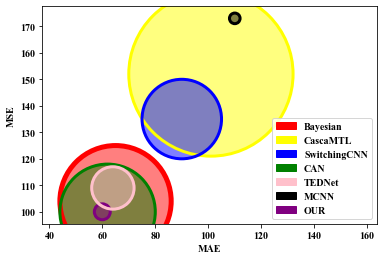

In [82]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('font',family='Times New Roman')

fig,ax = plt.subplots()
plt.axis("equal")

plt.scatter(MAE[1], MSE[1], color="k",alpha=0)
plt.scatter(MAE[2], MSE[2], color="k",alpha=0)
plt.scatter(MAE[3], MSE[3], color="k",alpha=0)
plt.scatter(MAE[5], MSE[5], color="k",alpha=0)
plt.scatter(MAE[6], MSE[6], color="k",alpha=0)
plt.scatter(MAE[4], MSE[4], color="k",alpha=0)
plt.scatter(MAE[0], MSE[0], color="k",alpha=0)

circle = plt.Circle((MAE[1], MSE[1]), 21, color='red', fill=True,alpha=0.5)
ax.add_artist(circle)
circle = plt.Circle((MAE[2], MSE[2]), 31, color='yellow', fill=True,alpha=0.5)
ax.add_artist(circle)
circle = plt.Circle((MAE[3], MSE[3]), 15, color='blue', fill=True,alpha=0.5)
ax.add_artist(circle)
circle = plt.Circle((MAE[5], MSE[5]), 18, color='green', fill=True,alpha=0.5)
ax.add_artist(circle)
circle = plt.Circle((MAE[6], MSE[6]), 3, color='purple', fill=True,alpha=0.5)
ax.add_artist(circle)
circle = plt.Circle((MAE[4], MSE[4]), 8, color='pink', fill=True,alpha=0.5)
ax.add_artist(circle)
circle = plt.Circle((MAE[0], MSE[0]), 2, color='black', fill=True,alpha=0.5)
ax.add_artist(circle)


circle = plt.Circle((MAE[1], MSE[1]), 21, color='red', fill=False,lw=5 )
ax.add_artist(circle)
circle = plt.Circle((MAE[2], MSE[2]), 31, color='yellow', fill=False,lw=3)
ax.add_artist(circle)
circle = plt.Circle((MAE[3], MSE[3]), 15, color='blue', fill=False,lw=3)
ax.add_artist(circle)
circle = plt.Circle((MAE[5], MSE[5]), 18, color='green', fill=False,lw=3)
ax.add_artist(circle)
circle = plt.Circle((MAE[6], MSE[6]), 3, color='purple', fill=False,lw=3)
ax.add_artist(circle)
circle = plt.Circle((MAE[4], MSE[4]), 8, color='pink', fill=False,lw=3)
ax.add_artist(circle)
circle = plt.Circle((MAE[0], MSE[0]), 2, color='black', fill=False,lw=3)
ax.add_artist(circle)

plt.xlim(100, 101)

plt.xlabel('MAE')
plt.ylabel('MSE')
plt.legend(["CF"])

patches = [mpatches.Patch(color="red", label="Bayesian"),
           mpatches.Patch(color="yellow", label="CascaMTL"),
           mpatches.Patch(color="blue", label="SwitchingCNN"),
           mpatches.Patch(color="green", label="CAN"),
           mpatches.Patch(color="pink", label="TEDNet"),
           mpatches.Patch(color="black", label="MCNN"),
           mpatches.Patch(color="purple", label="OUR"),
          ]
plt.legend(handles=patches,  loc=4)
plt.savefig("./4.pdf")